In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# 7資產2003/05~2019/04

In [2]:
df = pd.read_csv('/Users/Kang/Documents/碩一下學期/張森林 機器人理財專題研究/HW3/CSVs/0_ETF 2003_2019.csv', index_col = 'Date')
df = df.set_index(pd.DatetimeIndex(df.index))
df = df['2003-05-01':]

In [3]:
#df.plot(figsize=(12,8), grid=True)

In [4]:
all_ticker = df.columns.tolist()

#挑出所有年月的第一天，總共16年，192個月
all_rebalance_day = []
for i in range(df.index.year.min(), df.index.year.max()+1):
    for j in range(1, 13):
        mday = df.loc[(df.index.year == i) & (df.index.month == j)].index.day.min()
        all_rebalance_day.append(str(i) + '-' + ('0'+str(j) if j < 10 else str(j)) + '-' + ('0'+str(mday)))

all_rebalance_day = [i for i in all_rebalance_day if i[9:] != 'nan']

# 設定target volatility，使用前六個月股價以及蒙地卡羅隨機權重，算出本月AACR & AACRV，取1000次隨機中小於target volatility且期望報酬最大者

In [5]:
target_volatility = 0.07

In [6]:
w = {'EEM' : 0.3, 'EFA' : 0.4, 'IYR' : 0.2, 'LQD' : 0.4, 'SHY' : 1, 'TLT' : 0.4, 'VTI' : 0.4}

In [7]:
def get_weight():
    #result = {}
    #for i in my_l:
        #result[i] = random.uniform(0, w[i])
    result = {i : random.uniform(0, w[i]) for i in all_ticker}
    result = {k: v / total for total in (sum(result.values()),) for k, v in result.items()}
    return result

In [8]:
'''
import operator
import functools

def sumproduct(*lists):
    return sum(functools.reduce(operator.mul, data) for data in zip(*lists))
'''

'\nimport operator\nimport functools\n\ndef sumproduct(*lists):\n    return sum(functools.reduce(operator.mul, data) for data in zip(*lists))\n'

In [9]:
def get_first_base(i, R):
    AACRV = target_volatility + 0.01
    while AACRV > target_volatility:
        weight = get_weight()
        AACR = (252/len(R)) * sum((R[i].sum()) * weight[i] for i in all_ticker)
        AACRV = ((252/len(R)) * sum(weight[i] * weight[j] * (R[i] * R[j]).sum() for i in all_ticker for j in all_ticker)) ** 0.5
    return AACRV, AACR, weight

def gen_result(i, times = 1000):
    #每次rebalance前的look back period
    look_back = df.loc[all_rebalance_day[i]:all_rebalance_day[i+6]].iloc[:-1]
    
    #全部ETF年化報酬率
    R = np.log(look_back) - np.log(look_back.shift()) 
    #既然算realized volatility已經要用到上式，那也不用為AACR特別用一種方式算
    #R = (np.log(look_back.iloc[-1]) - np.log(look_back.iloc[0]))*252/len(look_back)
    
    #先取得第一個符合條件的點當基礎
    tem_max_stdev, tem_max_return, tem_weight = get_first_base(i, R)
    
    #隨機次數
    for t in range(times):
        
        #每次隨機均利用先前函數，重新生成一組權重
        #weight記錄下來
        weight = get_weight()

        #加權平均，確保每個etf都是乘到自己的權重
        #AACR = sumproduct(R[all_ticker].values.tolist(), [weight[k] for k in all_ticker])
        AACR = (252/len(R)) * sum((R[i].sum()) * weight[i] for i in all_ticker)
        AACRV = ((252/len(R)) * sum(weight[i] * weight[j] * (R[i] * R[j]).sum() for i in all_ticker for j in all_ticker)) ** 0.5

        #算起來不一樣
        #cov = R.cov()
        #w_w = np.array([list(weight.values())])
        #w_w_T = w_w.T
        #matrix_std = float((w_w.dot(cov).dot(w_w_T) * (252/len(R))) ** 0.5)
        
        #因為先前已經找出第一個符合條件的，所以現在只要找比該起始點期望報酬更大者就行了，即使是負的也沒關係
        if (AACRV <= target_volatility) & (AACR > tem_max_return):
            [tem_max_stdev, tem_max_return, tem_weight] = [AACRV, AACR, weight]
        else:
            pass           
        
    return tem_max_stdev, tem_max_return, tem_weight

In [10]:
#df_w = pd.DataFrame(index = all_rebalance_day, columns = all_ticker)
#df_w = df_w.set_index(pd.DatetimeIndex(df_w.index))
#df_w['volatility'] = np.nan
#df_w['expected return'] = np.nan

In [11]:
#大概要跑一個半小時
'''
for i in range(len(df_w) - 6):
    try:
        df_w['volatility'].iloc[i + 6], df_w['expected return'].iloc[i + 6], tem_weight = gen_result(i)
        for k, v in tem_weight.items():
            df_w[k].iloc[i + 6] = v
    except:
        pass
'''

"\nfor i in range(len(df_w) - 6):\n    try:\n        df_w['volatility'].iloc[i + 6], df_w['expected return'].iloc[i + 6], tem_weight = gen_result(i)\n        for k, v in tem_weight.items():\n            df_w[k].iloc[i + 6] = v\n    except:\n        pass\n"

In [12]:
#df_w.to_csv('/Users/Kang/Desktop/MonteCarlo_weight.csv')

# 上一部計算得出的逐月前六個月波動率小於target volatility，期望報酬最大之權重組合

In [13]:
df_w = pd.read_csv('/Users/Kang/Documents/碩一下學期/張森林 機器人理財專題研究/HW3/CSVs/1_MonteCarlo_weight.csv', index_col = 0)
df_w = df_w.set_index(pd.DatetimeIndex(df_w.index))
df_w = df_w[6:]
df_w['No'] = range(len(df_w))

In [14]:
df_w.head(10)

,EEM,EFA,IYR,LQD,SHY,TLT,VTI,volatility,expected return,No
2003-11-03,0.270363,0.056468,0.094849,0.170135,0.335576,0.025830,0.046780,0.067602,0.262768,0
2003-12-01,0.086148,0.114481,0.395577,0.032981,0.278100,0.056668,0.036045,0.068800,0.213878,1
2004-01-02,0.202062,0.150753,0.120944,0.180933,0.280277,0.001602,0.063429,0.069585,0.266777,2
2004-02-02,0.115033,0.250399,0.228867,0.163004,0.136754,0.101602,0.004341,0.067502,0.319127,3
2004-03-01,0.058943,0.194529,0.158118,0.119349,0.009789,0.284487,0.174784,0.069183,0.295554,4
2004-04-01,0.054666,0.050370,0.368856,0.184586,0.169279,0.040668,0.131575,0.064040,0.250935,5
2004-05-03,0.059851,0.304590,0.017009,0.312784,0.246926,0.015972,0.042868,0.069755,0.096141,6
2004-06-01,0.011508,0.195220,0.046222,0.074831,0.373305,0.043944,0.254971,0.069255,0.071462,7
2004-07-01,0.002992,0.029353,0.134921,0.030459,0.498735,0.056507,0.247033,0.058480,0.036928,8
2004-08-02,0.003740,0.004889,0.024956,0.199398,0.489753,0.226766,0.050498,0.047549,-0.006528,9


In [15]:
df_w.tail(10)

,EEM,EFA,IYR,LQD,SHY,TLT,VTI,volatility,expected return,No
2018-07-02,0.002365,0.158690,0.006283,0.001450,0.491849,0.041990,0.297372,0.065789,0.001371,176
2018-08-01,0.001048,0.006527,0.213332,0.000984,0.304854,0.189860,0.283396,0.069965,0.038814,177
2018-09-04,0.086237,0.083095,0.326407,0.126487,0.000548,0.200696,0.176530,0.069678,0.120727,178
2018-10-01,0.031248,0.177133,0.059934,0.055284,0.016394,0.122913,0.537093,0.069893,0.139705,179
2018-11-01,0.008524,0.035319,0.113588,0.012976,0.490972,0.094379,0.244243,0.041670,0.012706,180
2018-12-03,0.009791,0.006938,0.134723,0.018822,0.683054,0.136226,0.010446,0.025333,0.014794,181
2019-01-02,0.010805,0.000241,0.056000,0.163328,0.485029,0.251563,0.033035,0.030491,0.010409,182
2019-02-01,0.087913,0.029958,0.177945,0.317180,0.123207,0.243536,0.020261,0.053980,0.048251,183
2019-03-01,0.240466,0.025542,0.046081,0.370854,0.283545,0.015796,0.017716,0.064730,0.038494,184
2019-04-01,0.006249,0.023111,0.151800,0.158386,0.296414,0.333207,0.030831,0.044190,0.126268,185


Text(0.5, 1.0, '1000 times MonteCarlo Simulation output for each month')

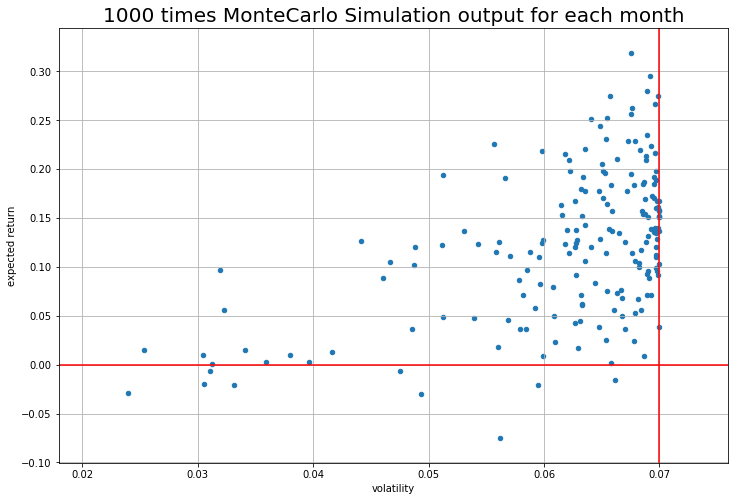

In [16]:
df_w.plot.scatter(x = 'volatility', y = 'expected return', figsize=(12,8), grid = True)
plt.axvline(target_volatility, color='r')
plt.axhline(0, color='r')
plt.title('1000 times MonteCarlo Simulation output for each month', size = 20)

# 計算逐月購買單位數及逐日指數，分成有無減掉無風險利率＆0.5%成本率

In [17]:
price_to_rebal = 100
price_to_rebal_adj = 100

In [18]:
Daily_Index_Cost = 0.5/100
Nat_fund_rate = pd.read_csv('/Users/Kang/Documents/碩一下學期/張森林 機器人理財專題研究/HW3/CSVs/0_DFF.csv', index_col = 'DATE')
Nat_fund_rate = Nat_fund_rate.set_index(pd.DatetimeIndex(Nat_fund_rate.index))
#換算成日報酬並整形
Nat_fund_rate_daily = (Nat_fund_rate/100 + Daily_Index_Cost) / 252
Nat_fund_rate_daily = Nat_fund_rate_daily.loc[df.index]

In [19]:
#為df新增一欄用於儲存每日指數，另一欄用於儲存減無風險報酬及成本率後之結果
df['Index'] = np.nan
df['Index_Adj'] = np.nan

#把無風險利率以及成本率跟df合併在一起
df = pd.merge(df, Nat_fund_rate_daily, on = df.index)
df = df.rename(index=str, columns={"key_0": "Date"})
df = df.set_index('Date')
df = df.set_index(pd.DatetimeIndex(df.index))

#新增df_units用於儲存各etf逐月購買單位數
df_units = pd.DataFrame(index = all_rebalance_day, columns = all_ticker)
df_units = df_units.set_index(pd.DatetimeIndex(df_units.index))
df_units = df_units[6:]

#新增df_units_adj用於儲存減掉無風險利率以及成本率後各etf逐月購買單位數
df_units_adj = pd.DataFrame(index = all_rebalance_day, columns = all_ticker)
df_units_adj = df_units_adj.set_index(pd.DatetimeIndex(df_units_adj.index))
df_units_adj = df_units_adj[6:]

In [20]:
for day in range(len(df_w) - 1):
    
    #先利用df_w中的權重計算購買單位數，有無減無風險利率分開紀錄
    for etf in all_ticker:
        df_units[etf].iloc[day] = price_to_rebal * df_w[etf].iloc[day] / df[etf].loc[df_w.index[day]]
        df_units_adj[etf].iloc[day] = price_to_rebal_adj * df_w[etf].iloc[day] / df[etf].loc[df_w.index[day]]
    
    #取出該月區段所有股價
    df_tem = df.loc[(df.index >= df_w.index[day]) & (df.index < df_w.index[day+1])]
    
    #對該月區段逐日計算Index，減無風險index是計算出來之數值減掉當日無風險利率及成本率
    for i in df_tem.index:
        df['Index'].loc[i] = sum(df_units[etf].iloc[day] * df_tem[etf].loc[i] for etf in all_ticker)
        df['Index_Adj'].loc[i] = sum(df_units_adj[etf].iloc[day] * df_tem[etf].loc[i] for etf in all_ticker) * (1 - df['DFF'].loc[i])
    
    #將price_to_rebal更新為該月最後一天的Index
    price_to_rebal = df['Index'].loc[df_tem.index[-1]]
    price_to_rebal_adj = df['Index_Adj'].loc[df_tem.index[-1]]

In [21]:
#處理最後一個月的購買單位數以及index/Index_Adj
day = len(df_w) - 1
for etf in all_ticker:
    df_units[etf].iloc[day] = price_to_rebal * df_w[etf].iloc[day] / df[etf].loc[df_w.index[day]]
    df_units_adj[etf].iloc[day] = price_to_rebal_adj * df_w[etf].iloc[day] / df[etf].loc[df_w.index[day]]
df_tem = df.loc[(df.index.year == df_w.index.year[-1]) & (df.index.month == df_w.index.month[-1])]
for i in df_tem.index:
    df['Index'].loc[i] = sum(df_units[etf].iloc[day] * df_tem[etf].loc[i] for etf in all_ticker)
    df['Index_Adj'].loc[i] = sum(df_units_adj[etf].iloc[day] * df_tem[etf].loc[i] for etf in all_ticker) * (1 - df['DFF'].loc[i])

In [22]:
df.loc[df.index >= df_w.index[0]]

,EEM,EFA,IYR,LQD,SHY,TLT,VTI,Index,Index_Adj,DFF
Date,,,,,,,,,,
2003-11-03,12.796095,27.308607,24.608467,55.720154,62.416981,48.750778,37.787868,100.000000,99.993968,0.000060
2003-11-04,12.831465,27.459066,24.678946,55.806408,62.462616,49.027866,37.676605,100.184787,100.178903,0.000059
2003-11-05,12.848309,27.302053,24.639797,55.415607,62.401783,48.693039,37.743359,100.011311,100.005437,0.000059
2003-11-06,12.756516,27.062193,24.822495,55.111069,62.333405,48.236916,37.902813,99.704008,99.698073,0.000060
2003-11-07,12.769987,27.312969,24.934746,55.217640,62.280212,48.208050,37.732239,99.808888,99.803027,0.000059
2003-11-10,12.593986,27.086172,24.882534,55.055222,62.295395,48.167656,37.543110,99.303019,99.297148,0.000059
2003-11-11,12.432296,26.983690,24.731150,55.293747,62.295395,48.173420,37.472645,98.946266,98.940416,0.000059
2003-11-12,12.653772,27.546301,25.104401,55.324257,62.333405,48.525600,37.925072,99.778831,99.772892,0.000060
2003-11-13,12.751463,27.703312,25.159204,55.847000,62.470135,49.276108,37.984394,100.319060,100.313128,0.000059


Text(0.5, 1.0, 'Base Index & (Adj. for Federal Funds Rate & Daily Cost)')

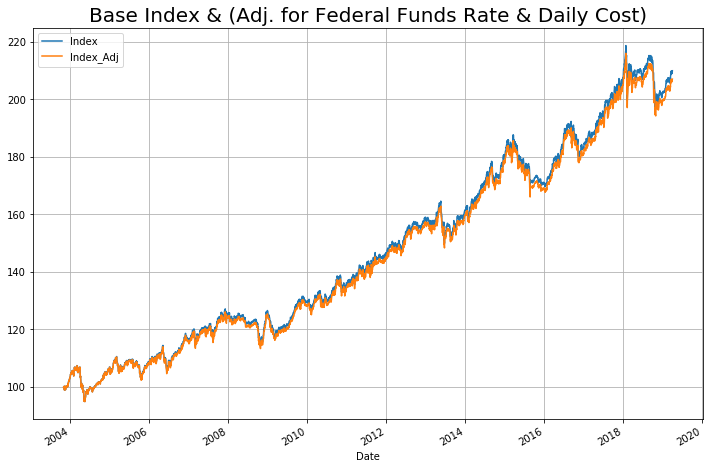

In [23]:
df[['Index', 'Index_Adj']].plot(figsize=(12,8), grid = True)
plt.title('Base Index & (Adj. for Federal Funds Rate & Daily Cost)', size = 20)

Text(0.5, 1.0, 'Adj. Base Index daily percentage change')

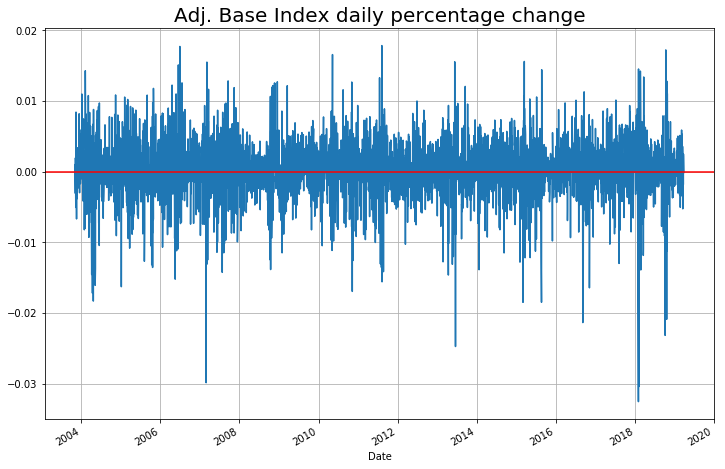

In [24]:
df['Index_Adj'].pct_change().plot(figsize=(12,8), grid = True)
plt.axhline(0, color='r')
plt.title('Adj. Base Index daily percentage change', size = 20)

In [25]:
#df_units.to_csv('/Users/Kang/Desktop/units.csv')
#df_units_adj.to_csv('/Users/Kang/Desktop/units_minus_df.csv')

# 畫出某個月的1000次隨機投資組合之分佈，可用於檢查結果

In [26]:
def gen_result_for_graph(i, times = 1000):
    #每次rebalance前的look back period
    look_back = df.loc[all_rebalance_day[i]:all_rebalance_day[i+6]].iloc[:-1]
    
    #全部ETF年化報酬率
    R = np.log(look_back) - np.log(look_back.shift()) 
    
    #再用另一個dataframe來存前一資料裡，每次隨機所產生的期望值、標準差
    result = pd.DataFrame(columns = ('stdev', 'mean'))
    
    #隨機次數
    for t in range(times):
        
        #每次隨機均利用先前函數，重新生成一組權重
        #weight記錄下來
        weight = get_weight()

        #加權平均，確保每個etf都是乘到自己的權重
        AACR = (252/len(R)) * sum((R[i].sum()) * weight[i] for i in all_ticker)
        AACRV = ((252/len(R)) * sum(weight[i] * weight[j] * (R[i] * R[j]).sum() for i in all_ticker for j in all_ticker)) ** 0.5

        #計算出報酬率之平均及標準差，加入result裡
        result = result.append({'stdev' : AACRV, 'mean' : AACR}, ignore_index = True)
        
    return result

def gen_graph(i, times = 1000):
    plt.figure(figsize=(15,10))
    result =  gen_result_for_graph(i, times)
    plt.scatter(result['stdev'], result['mean'])

    #產生圖之資訊
    plt.xlabel('Standard Deviation', size = 16)
    plt.ylabel('Expected Return', size = 16)
    plt.title(str(times) + ' times of MonteCarlo for 7 assets on '+ all_rebalance_day[i+6], size = 18)
    plt.axvline(target_volatility, color='r')
    plt.axhline(0, color='r')
    
    return result

-0.02579982847454493

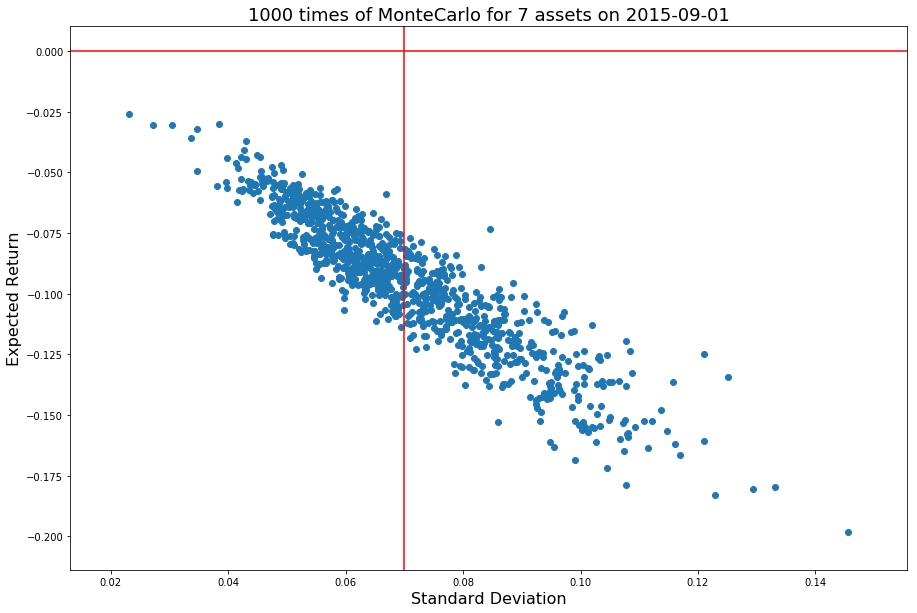

In [27]:
#用於檢查，畫出任一個月的模擬資產組合
result = gen_graph(142,1000)

#小於等於target volatility中期望報酬最大的
result['mean'].loc[(result['stdev'] <= target_volatility)].max()

In [28]:
df_w.loc[df_w['expected return'] < 0]

,EEM,EFA,IYR,LQD,SHY,TLT,VTI,volatility,expected return,No
2004-08-02,0.003740,0.004889,0.024956,0.199398,0.489753,0.226766,0.050498,0.047549,-0.006528,9
2008-08-01,0.013740,0.079769,0.002079,0.024330,0.657794,0.187247,0.035040,0.033183,-0.021105,57
2008-10-01,0.025698,0.009332,0.115246,0.067873,0.529193,0.249011,0.003647,0.049336,-0.029814,59
2008-11-03,0.006258,0.029011,0.048758,0.058872,0.517566,0.321967,0.017568,0.056151,-0.074995,60
2009-03-02,0.006150,0.010512,0.022418,0.156030,0.681660,0.116811,0.006419,0.059504,-0.021278,64
2009-07-01,0.019280,0.025090,0.021324,0.161443,0.619524,0.089220,0.064119,0.066125,-0.015535,68
2015-09-01,0.007233,0.030072,0.002044,0.077680,0.709021,0.135490,0.038460,0.030505,-0.019257,142
2015-10-01,0.000677,0.043452,0.030764,0.006987,0.760774,0.113194,0.044152,0.023935,-0.028995,143
2015-11-02,0.020125,0.000532,0.083343,0.119956,0.672130,0.016098,0.087816,0.031047,-0.006774,144


# Monitor: 計算每20日的年化標準差

In [29]:
#每20日計算一次volatility並年化，採rowling的方式
df['m_vol_check'] = np.nan

#剔除掉沒有計算Index_Adj的日子，也就是前六個月，從2003/11/03開始
tt = df.loc[df.index >= df_w.index[0]]

#計算平均一個月有幾天
avg_day = round(len(tt) / len(all_rebalance_day))

for i in range(avg_day, len(tt)):
    #原本錯誤的
    #df['m_vol_check'].loc[tt.index[i]] = ((np.log(tt['Index_Adj'].iloc[i-avg_day : i])-np.log(tt['Index_Adj'].iloc[i-avg_day : i].shift())).std() * ((252/avg_day)**0.5))
    df['m_vol_check'].loc[tt.index[i]] = ((np.log(tt['Index_Adj'].iloc[i-avg_day : i])-np.log(tt['Index_Adj'].iloc[i-avg_day : i].shift())).std() * ((252)**0.5))

Text(0.5, 1.0, 'Daily realized volatility of past 20 days')

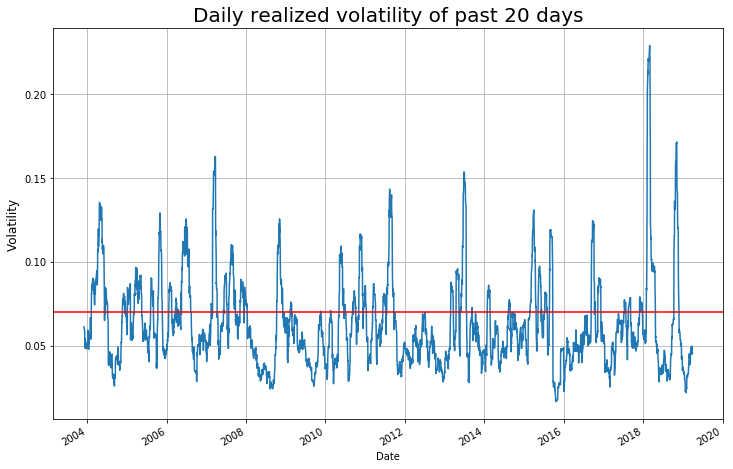

In [30]:
df['m_vol_check'].plot(figsize=(12,8), grid = True)
plt.axhline(target_volatility, color='r')
plt.ylabel('Volatility', size = 12)
plt.title('Daily realized volatility of past 20 days', size = 20)

In [31]:
df.head(10)

,EEM,EFA,IYR,LQD,SHY,TLT,VTI,Index,Index_Adj,DFF,m_vol_check
Date,,,,,,,,,,,
2003-05-01,8.845684,21.854733,20.332550,54.742962,62.131554,50.109718,31.728981,NaN,NaN,0.000071,NaN
2003-05-02,8.981265,22.044455,20.512768,54.556934,62.063702,49.715641,32.174667,NaN,NaN,0.000069,NaN
2003-05-05,9.078113,22.212360,20.751383,54.801701,62.108910,49.980209,32.156261,NaN,NaN,0.000070,NaN
2003-05-06,9.124428,22.681206,20.868158,55.090515,62.199436,50.227921,32.377258,NaN,NaN,0.000071,NaN
2003-05-07,9.107585,22.471861,20.809767,55.457653,62.214458,50.813305,32.266743,NaN,NaN,0.000071,NaN
2003-05-08,9.027582,22.133854,20.888460,55.462543,62.184330,50.937157,31.935236,NaN,NaN,0.000070,NaN
2003-05-09,9.133689,22.412983,21.043297,55.364632,62.169254,50.987850,32.395672,NaN,NaN,0.000069,NaN
2003-05-12,9.260852,22.591799,21.208298,55.555569,62.214458,51.308708,32.782421,NaN,NaN,0.000069,NaN
2003-05-13,9.208641,22.589619,21.243834,55.560413,62.199436,51.421249,32.745598,NaN,NaN,0.000069,NaN


In [32]:
df.tail(10)

,EEM,EFA,IYR,LQD,SHY,TLT,VTI,Index,Index_Adj,DFF,m_vol_check
Date,,,,,,,,,,,
2019-03-19,43.580002,65.580002,84.676994,116.124863,83.451607,120.889305,144.737473,208.563120,205.698482,0.000115,0.049094
2019-03-20,43.650002,65.610001,84.959999,116.910164,83.571159,122.153862,144.140686,209.305312,206.430398,0.000115,0.048541
2019-03-21,43.709999,65.570000,86.400002,117.128853,83.571159,122.422699,145.831543,209.731680,206.850910,0.000115,0.047663
2019-03-22,42.430000,64.309998,85.879997,117.844566,83.710625,124.324509,142.787994,208.627393,205.761791,0.000115,0.044983
2019-03-25,42.529999,64.400002,85.900002,118.083138,83.800285,124.523651,142.690002,208.978137,206.107798,0.000115,0.049543
2019-03-26,42.660000,64.720001,86.540001,118.132835,83.790329,124.434044,143.789993,209.280055,206.405570,0.000115,0.049716
2019-03-27,42.200001,64.750000,86.360001,118.291893,83.860062,125.579109,143.130005,208.895465,206.026180,0.000115,0.045128
2019-03-28,42.480000,64.589996,87.110001,118.441002,83.850090,126.017212,143.759995,209.414345,206.537934,0.000115,0.045004
2019-03-29,42.919998,64.860001,87.040001,118.351532,83.800285,125.897736,144.710007,209.867468,206.984669,0.000116,0.045296


In [33]:
#df.to_csv('/Users/Kang/Desktop/Index_result.csv')

In [34]:
#To Do
#daily deleverage就是如果risk是10%，而cap是8%，那就整個資產乘0.8，0.2放到money market
#採用0~1隨機抽樣再高次方，如果符合上下界就輸出，如果不符就重抽，在最大報酬為負時改成這樣調整，可以抽到正報酬資產最大的權重